# Welcome to `NeuroEvoBench` 👋 [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuroevobench/neuroevobench/blob/main/examples/neb_introduction.ipynb)

In the following mini-tutorial we walk through the core functionality of the `NeuroEvoBench` benchmark. More specifically, we show how to run a random search sweep using a Simple Evolution Strategy (ES) implemented in [`evosax`](https://github.com/RobertTLange/evosax/) on a set of simple (and fast to evaluate) BBOB functions. All of the task evaluations follow the same protocol. Let's start by importing the benchmark and `evosax`.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import evosax
    import neuroevobench
except Exception:
    !pip install -q git+https://github.com/RobertTLange/evosax.git@main
    !pip install -q git+https://github.com/neuroevobench/neuroevobench.git@main
    
    import evosax
    import neuroevobench

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


envpool not installed, Atari problems will not work.
envpool not installed, Atari problems will not work.
You need to install brax for Brax tasks:
  pip install git+https://github.com/google/brax.git@main


# Evolution Strategy Setup & `evosax` API 

In [1]:
import jax
import jax.numpy as jnp
from evosax import SimpleES

# Instantiate the evolution strategy instance
strategy = SimpleES(num_dims=2, popsize=10)

# Get default hyperparameters (e.g. lrate, etc.)
es_params = strategy.default_params
es_params = es_params.replace(init_min= -3, init_max=3)

# Initialize the strategy
rng = jax.random.PRNGKey(0)
state = strategy.initialize(rng, es_params)

# Have a look at the hyperparameters (change if desired)
es_params

EvoParams(c_sigma=0.1, c_m=1.0, sigma_init=1.0, init_min=-3, init_max=3, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

# `BBOB` task setup & running a single eval

In [3]:
from neuroevobench.problems.bbob import BBOBEvaluator

popsize = 10
num_dims = 2
es_config = {}
es_params = {}
num_eval_runs = 5
seed_id = 42
num_generations = 50


# 1. Setup task evaluator with strategy
evaluator = BBOBEvaluator(
    popsize=popsize,
    num_dims=num_dims,
    es_strategy=SimpleES,
    es_config=es_config,
    es_params=es_params,
    num_eval_runs=num_eval_runs,
    seed_id=seed_id,
)

# 2. Run the ES loop with logging
evaluator.run(num_generations)

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50} {'test_eval_perf': -213.34922790527344, 'Sphere_mean': DeviceArray(0.00208277, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.59280723, dtype=float32), 'Discus_mean': DeviceArray(3785.8782, dtype=float32), 'RastriginRotated_mean': DeviceArray(23.384197, dtype=float32), 'Schwefel_mean': DeviceArray(3.7671869, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(28.045166, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.550129, dtype=float32), 'Weierstrass_mean': DeviceArray(29.481977, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.54004943, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(14.863263, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(85.39087, dtype=float32), 'RastriginOriginal_mean': DeviceArray(23.81484, dtype=float32), 'LinearSlope_mean': DeviceArray(-266.49292, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray(1.094798, 

In [4]:
# Average task performance across all BBOB functions
evaluator.fitness_eval

-213.34922790527344

# Sequential Random Search Sweep

In [5]:
import copy
from dotmap import DotMap

from mle_hyperopt import RandomSearch
from neuroevobench.problems import neb_eval_loops

In [6]:
# Setup the search strategy for sequential evaluation
hyper_strategy = RandomSearch(
    real={"sigma_init": {"begin": 0.01, "end": 0.5, "prior": "uniform"}},
    search_config={
        "refine_after": 10,
        "refine_top_k": 5
    },
    maximize_objective=True,
    seed_id=0,
    verbose=True,
)


config = DotMap({
    "strategy_name": "SimpleES",  # Uses SimpleES implemented by evosax
    "popsize": 10,
    "num_dims": 2,
    "es_config": {},
    "es_params": {},
    "num_eval_runs": 5,
    "seed_id": 42,
    "num_generations": 50
})

              MLE-Hyperopt Random Hyperspace 🚀                        
                                                                                
           🌻 Variable   Type   Search Range ↔                                  
          ────────────────────────────────────────────────────────────          
           sigma_init    real   Begin: 0.01, End: 0.5, Prior: uniform 

In [7]:
# Run the random search hyperparameter optimization loop
for search_iter in range(10):
    # Augment the default params with the proposed parameters
    proposal_params = hyper_strategy.ask()
    eval_config = copy.deepcopy(config)
    for k, v in proposal_params.items():
        eval_config.es_config[k] = v

    # Evaluate the parameter config by running a ES loop
    performance, solution = neb_eval_loops["bbob"](
        eval_config,
        log=None,
        search_iter=search_iter,
    )

    # Update search strategy - Note we minimize!
    hyper_strategy.tell(proposal_params, float(performance))

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 0} {'test_eval_perf': -21.574684143066406, 'Sphere_mean': DeviceArray(0.00016203, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.27455124, dtype=float32), 'Discus_mean': DeviceArray(262.93015, dtype=float32), 'RastriginRotated_mean': DeviceArray(11.297349, dtype=float32), 'Schwefel_mean': DeviceArray(3.3801732, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(2.0099385, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.07498827, dtype=float32), 'Weierstrass_mean': DeviceArray(0.63930243, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.17726558, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.454251, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(20.129179, dtype=float32), 'RastriginOriginal_mean': DeviceArray(12.772013, dtype=float32), 'LinearSlope_mean': DeviceArray(-21.587547, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(3.9564817, dtype=float32), 'RosenbrockOriginal_mean': Devi

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 1   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:20:15 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 0  │ -21.575 │ 'sigma_init': 0.279                    │    
   │ Best in Batch │ 0  │ -21.575 │ 'sigma_init': 0.279                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 1} {'test_eval_perf': -34.40479278564453, 'Sphere_mean': DeviceArray(0.00027059, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.3538096, dtype=float32), 'Discus_mean': DeviceArray(594.74286, dtype=float32), 'RastriginRotated_mean': DeviceArray(17.108307, dtype=float32), 'Schwefel_mean': DeviceArray(2.83757, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(2.1512241, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.11554252, dtype=float32), 'Weierstrass_mean': DeviceArray(1.4634793, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.14000084, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.836069, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(18.11529, dtype=float32), 'RastriginOriginal_mean': DeviceArray(12.940608, dtype=float32), 'LinearSlope_mean': DeviceArray(-49.27611, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.3231727, dtype=float32), 'RosenbrockOriginal_mean': DeviceArray

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 2   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:20:44 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 0  │ -21.575 │ 'sigma_init': 0.279                    │    
   │ Best in Batch │ 1  │ -34.405 │ 'sigma_init': 0.36                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 2} {'test_eval_perf': -20.56562614440918, 'Sphere_mean': DeviceArray(0.0001942, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.31130585, dtype=float32), 'Discus_mean': DeviceArray(358.07855, dtype=float32), 'RastriginRotated_mean': DeviceArray(12.835216, dtype=float32), 'Schwefel_mean': DeviceArray(2.9397182, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-6.807995, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.07508777, dtype=float32), 'Weierstrass_mean': DeviceArray(0.54412144, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.2482125, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(7.413588, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(15.42706, dtype=float32), 'RastriginOriginal_mean': DeviceArray(10.985679, dtype=float32), 'LinearSlope_mean': DeviceArray(-30.565994, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.5632765, dtype=float32), 'RosenbrockOriginal_mean': DeviceAr

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 3   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:21:12 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 2  │ -20.566 │ 'sigma_init': 0.305                    │    
   │ Best in Batch │ 2  │ -20.566 │ 'sigma_init': 0.305                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 3} {'test_eval_perf': -21.532398223876953, 'Sphere_mean': DeviceArray(0.0001598, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.24979298, dtype=float32), 'Discus_mean': DeviceArray(259.4808, dtype=float32), 'RastriginRotated_mean': DeviceArray(9.697973, dtype=float32), 'Schwefel_mean': DeviceArray(2.5447729, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(5.2353005, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.06899687, dtype=float32), 'Weierstrass_mean': DeviceArray(0.67652655, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.20517544, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(11.736759, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(17.226957, dtype=float32), 'RastriginOriginal_mean': DeviceArray(11.250839, dtype=float32), 'LinearSlope_mean': DeviceArray(-20.93347, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(3.6041582, dtype=float32), 'RosenbrockOriginal_mean': DeviceA

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 4   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:21:39 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 2  │ -20.566 │ 'sigma_init': 0.305                    │    
   │ Best in Batch │ 3  │ -21.532 │ 'sigma_init': 0.277                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 4} {'test_eval_perf': -11.510205268859863, 'Sphere_mean': DeviceArray(9.861084e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.25958535, dtype=float32), 'Discus_mean': DeviceArray(111.71133, dtype=float32), 'RastriginRotated_mean': DeviceArray(2.9296498, dtype=float32), 'Schwefel_mean': DeviceArray(2.101896, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(1.368709, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.04910212, dtype=float32), 'Weierstrass_mean': DeviceArray(0.53529125, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.17522562, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(12.614681, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(6.6613955, dtype=float32), 'RastriginOriginal_mean': DeviceArray(6.2121634, dtype=float32), 'LinearSlope_mean': DeviceArray(-0.7584179, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.2605404, dtype=float32), 'RosenbrockOriginal_mean': Dev

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 5   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:22:07 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 5} {'test_eval_perf': -35.76628494262695, 'Sphere_mean': DeviceArray(0.00022201, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.29132554, dtype=float32), 'Discus_mean': DeviceArray(652.38855, dtype=float32), 'RastriginRotated_mean': DeviceArray(12.39189, dtype=float32), 'Schwefel_mean': DeviceArray(3.121177, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(10.0717125, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.09824301, dtype=float32), 'Weierstrass_mean': DeviceArray(0.33906385, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.2017144, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(6.403543, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(21.40122, dtype=float32), 'RastriginOriginal_mean': DeviceArray(21.23364, dtype=float32), 'LinearSlope_mean': DeviceArray(-37.743877, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.3231727, dtype=float32), 'RosenbrockOriginal_mean': DeviceArr

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 6   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:22:34 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 5  │ -35.766 │ 'sigma_init': 0.326                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 6} {'test_eval_perf': -13.989948272705078, 'Sphere_mean': DeviceArray(0.0001049, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.23269546, dtype=float32), 'Discus_mean': DeviceArray(117.24387, dtype=float32), 'RastriginRotated_mean': DeviceArray(7.330785, dtype=float32), 'Schwefel_mean': DeviceArray(2.3668888, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-2.282684, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.04535997, dtype=float32), 'Weierstrass_mean': DeviceArray(0.18937294, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.1843955, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(10.316733, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(8.109244, dtype=float32), 'RastriginOriginal_mean': DeviceArray(6.098723, dtype=float32), 'LinearSlope_mean': DeviceArray(-3.0770617, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.2605404, dtype=float32), 'RosenbrockOriginal_mean': DeviceAr

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 7   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:23:04 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 6  │ -13.99  │ 'sigma_init': 0.224                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 7} {'test_eval_perf': -47.748043060302734, 'Sphere_mean': DeviceArray(0.0004161, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.3204442, dtype=float32), 'Discus_mean': DeviceArray(784.27423, dtype=float32), 'RastriginRotated_mean': DeviceArray(16.46692, dtype=float32), 'Schwefel_mean': DeviceArray(3.0402076, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(15.003089, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.15439427, dtype=float32), 'Weierstrass_mean': DeviceArray(1.420051, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.38622415, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(13.053284, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(23.361307, dtype=float32), 'RastriginOriginal_mean': DeviceArray(18.989624, dtype=float32), 'LinearSlope_mean': DeviceArray(-78.66348, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArr

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 8   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:23:32 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 7  │ -47.748 │ 'sigma_init': 0.447                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 8} {'test_eval_perf': -58.46377182006836, 'Sphere_mean': DeviceArray(0.00048427, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.45827642, dtype=float32), 'Discus_mean': DeviceArray(528.646, dtype=float32), 'RastriginRotated_mean': DeviceArray(17.642885, dtype=float32), 'Schwefel_mean': DeviceArray(2.790366, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(3.714896, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.16452864, dtype=float32), 'Weierstrass_mean': DeviceArray(1.4863092, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.20941137, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(3.7961311, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(20.20664, dtype=float32), 'RastriginOriginal_mean': DeviceArray(14.773859, dtype=float32), 'LinearSlope_mean': DeviceArray(-90.627495, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.4745407, dtype=float32), 'RosenbrockOriginal_mean': DeviceArra

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 9   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:24:00 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 4  │ -11.51  │ 'sigma_init': 0.218                    │    
   │ Best in Batch │ 8  │ -58.464 │ 'sigma_init': 0.482                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 9} {'test_eval_perf': -7.899782180786133, 'Sphere_mean': DeviceArray(8.155926e-05, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.2507878, dtype=float32), 'Discus_mean': DeviceArray(73.76293, dtype=float32), 'RastriginRotated_mean': DeviceArray(1.3062929, dtype=float32), 'Schwefel_mean': DeviceArray(2.3835824, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-1.8977839, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.04990822, dtype=float32), 'Weierstrass_mean': DeviceArray(0.44519624, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.10217263, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(7.4899764, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(6.8864884, dtype=float32), 'RastriginOriginal_mean': DeviceArray(5.9448113, dtype=float32), 'LinearSlope_mean': DeviceArray(5.933947, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(1.9312643, dtype=float32), 'RosenbrockOriginal_mean': Devic

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 10  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:24:27 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   │ Best in Batch │ 9  │ -7.9    │ 'sigma_init': 0.198                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

 MLE-Hyperopt Random - 10 Evals - Top 5 - Refined Hyperspace 🚀          
                                                                                
         🌻 Variable   Type   Search Range ↔                                    
        ───────────────────────────────────────────────────────────────         
         sigma_init    real   Begin: 0.198, End: 0.305, Prior: uniform 

(<Figure size 432x288 with 1 Axes>,
 <Axes: title={'center': 'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

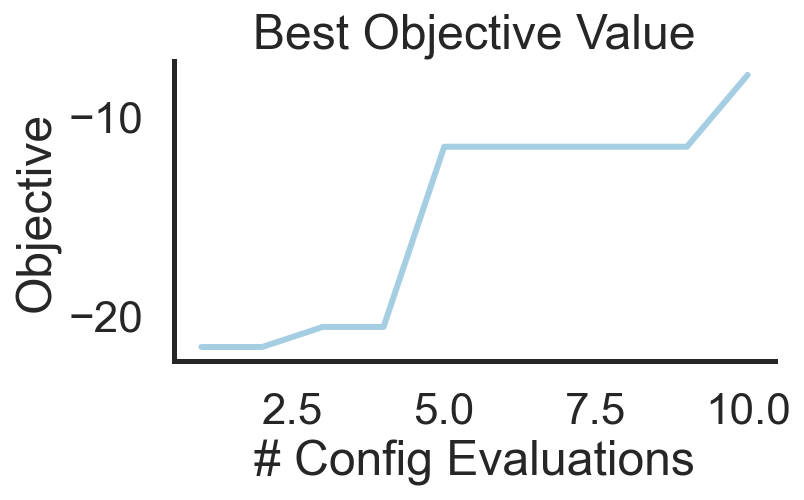

In [8]:
hyper_strategy.plot_best()

# Benchmark your own method

In [11]:
from typing import Tuple, Optional, Union
import jax
import jax.numpy as jnp
import chex
from flax import struct
from evosax import Strategy


@struct.dataclass
class EvoState:
    mean: chex.Array
    best_member: chex.Array
    best_fitness: float = jnp.finfo(jnp.float32).max
    gen_counter: int = 0


@struct.dataclass
class EvoParams:
    sigma_init: float = 0.1
    init_min: float = 0.0
    init_max: float = 0.0
    clip_min: float = -jnp.finfo(jnp.float32).max
    clip_max: float = jnp.finfo(jnp.float32).max


class HillClimber(Strategy):
    def __init__(
        self,
        popsize: int,
        num_dims: Optional[int] = None,
        pholder_params: Optional[Union[chex.ArrayTree, chex.Array]] = None,
        sigma_init: float = 1.0,
        **fitness_kwargs: Union[bool, int, float]
    ):
        """Hill Climbing Evolutionary Optimizer"""
        super().__init__(
            popsize,
            num_dims,
            pholder_params,
            **fitness_kwargs
        )
        self.strategy_name = "HillClimber"
        self.sigma_init = sigma_init

    @property
    def params_strategy(self) -> EvoParams:
        """Return default parameters of evolution strategy."""
        return EvoParams(sigma_init=self.sigma_init)

    def initialize_strategy(
        self, rng: chex.PRNGKey, params: EvoParams
    ) -> EvoState:
        """`initialize` the evolution strategy."""
        initialization = jax.random.uniform(
            rng,
            (self.num_dims,),
            minval=params.init_min,
            maxval=params.init_max,
        )
        state = EvoState(
            mean=initialization,
            best_member=initialization,
        )
        return state

    def ask_strategy(
        self, rng: chex.PRNGKey, state: EvoState, params: EvoParams
    ) -> Tuple[chex.Array, EvoState]:
        """`ask` for new proposed candidates to evaluate next."""
        # Sampling of N(0, 1) noise
        z = jax.random.normal(
            rng,
            (self.popsize, self.num_dims),
        )
        x = state.best_member + params.sigma_init.reshape(-1, 1) * z
        return x, state

    def tell_strategy(
        self,
        x: chex.Array,
        fitness: chex.Array,
        state: EvoState,
        params: EvoParams,
    ) -> EvoState:
        """`tell` update to ES state."""
        # No state update needed - everything happens with best_member update
        return state.replace(mean=state.best_member)


In [12]:
# Setup the search strategy for sequential evaluation
hyper_strategy = RandomSearch(
    real={"sigma_init": {"begin": 0.01, "end": 0.5, "prior": "uniform"}},
    search_config={
        "refine_after": 10,
        "refine_top_k": 5
    },
    maximize_objective=True,
    seed_id=0,
    verbose=True,
)

# Don't specify the search strategy name HERE!
config = DotMap({
    "popsize": 10,
    "num_dims": 2,
    "es_config": {},
    "es_params": {},
    "num_eval_runs": 5,
    "seed_id": 42,
    "num_generations": 50
})


# Run the random search hyperparameter optimization loop
for search_iter in range(10):
    # Augment the default params with the proposed parameters
    proposal_params = hyper_strategy.ask()
    eval_config = copy.deepcopy(config)
    for k, v in proposal_params.items():
        eval_config.es_config[k] = v

    # Evaluate the parameter config by running a ES loop
    performance, solution = neb_eval_loops["bbob"](
        eval_config,
        log=None,
        search_iter=search_iter,
        strategy_class=HillClimber  # Specify it HERE instead!
    )

    # Update search strategy - Note we minimize!
    hyper_strategy.tell(proposal_params, float(performance))

              MLE-Hyperopt Random Hyperspace 🚀                        
                                                                                
           🌻 Variable   Type   Search Range ↔                                  
          ────────────────────────────────────────────────────────────          
           sigma_init    real   Begin: 0.01, End: 0.5, Prior: uniform 

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 0} {'test_eval_perf': 6.226114749908447, 'Sphere_mean': DeviceArray(0.00039134, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.00930365, dtype=float32), 'Discus_mean': DeviceArray(1.9934813, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.9959071, dtype=float32), 'Schwefel_mean': DeviceArray(1.7992586, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.221428, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.00769582, dtype=float32), 'Weierstrass_mean': DeviceArray(0.02210636, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.04755829, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00654926, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.97592545, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.34312344, dtype=float32), 'LinearSlope_mean': DeviceArray(-136.19298, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.43844897, dtype=float32), 'RosenbrockOriginal_mean': 

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 1   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:26:44 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 0  │ 6.226   │ 'sigma_init': 0.279                    │    
   │ Best in Batch │ 0  │ 6.226   │ 'sigma_init': 0.279                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 1} {'test_eval_perf': 8.689719200134277, 'Sphere_mean': DeviceArray(0.00065354, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.00510243, dtype=float32), 'Discus_mean': DeviceArray(3.0792787, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.5276799, dtype=float32), 'Schwefel_mean': DeviceArray(1.5698105, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-18.927692, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.02009605, dtype=float32), 'Weierstrass_mean': DeviceArray(0.02794836, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.06473983, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00235233, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.6498133, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.4631978, dtype=float32), 'LinearSlope_mean': DeviceArray(-197.37914, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.5898178, dtype=float32), 'RosenbrockOriginal_mean': Dev

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 2   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:27:13 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 1  │ 8.69    │ 'sigma_init': 0.36                     │    
   │ Best in Batch │ 1  │ 8.69    │ 'sigma_init': 0.36                     │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 2} {'test_eval_perf': 7.087703704833984, 'Sphere_mean': DeviceArray(0.00046904, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.00250665, dtype=float32), 'Discus_mean': DeviceArray(1.8247932, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.68864834, dtype=float32), 'Schwefel_mean': DeviceArray(1.8622332, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.01887, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.01115397, dtype=float32), 'Weierstrass_mean': DeviceArray(0.07207473, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.04509301, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(5.283356e-05, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.2037247, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.09531277, dtype=float32), 'LinearSlope_mean': DeviceArray(-156.0335, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.73335665, dtype=float32), 'RosenbrockOriginal_mean': 

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 3   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:27:41 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 1  │ 8.69    │ 'sigma_init': 0.36                     │    
   │ Best in Batch │ 2  │ 7.088   │ 'sigma_init': 0.305                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 3} {'test_eval_perf': 6.13919734954834, 'Sphere_mean': DeviceArray(0.00038596, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.00496255, dtype=float32), 'Discus_mean': DeviceArray(1.9730377, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.93111515, dtype=float32), 'Schwefel_mean': DeviceArray(1.9036525, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.72016, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.01119483, dtype=float32), 'Weierstrass_mean': DeviceArray(0.03007596, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.05002716, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.0016386, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.9596121, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.39255083, dtype=float32), 'LinearSlope_mean': DeviceArray(-134.74754, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.43844897, dtype=float32), 'RosenbrockOriginal_mean': Dev

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 4   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:28:08 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 1  │ 8.69    │ 'sigma_init': 0.36                     │    
   │ Best in Batch │ 3  │ 6.139   │ 'sigma_init': 0.277                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 4} {'test_eval_perf': 4.181944847106934, 'Sphere_mean': DeviceArray(0.00023817, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.01387379, dtype=float32), 'Discus_mean': DeviceArray(1.2601849, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.545439, dtype=float32), 'Schwefel_mean': DeviceArray(2.3292692, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.746027, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.00375075, dtype=float32), 'Weierstrass_mean': DeviceArray(0.05502801, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.02057378, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00246124, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.66603124, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.10694652, dtype=float32), 'LinearSlope_mean': DeviceArray(-90.164734, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.28708068, dtype=float32), 'RosenbrockOriginal_mean': D

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 5   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:28:36 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 1  │ 8.69    │ 'sigma_init': 0.36                     │    
   │ Best in Batch │ 4  │ 4.182   │ 'sigma_init': 0.218                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 5} {'test_eval_perf': 7.729166030883789, 'Sphere_mean': DeviceArray(0.00053621, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.0127319, dtype=float32), 'Discus_mean': DeviceArray(2.1048124, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.6982812, dtype=float32), 'Schwefel_mean': DeviceArray(1.4710234, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-18.482258, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.00609142, dtype=float32), 'Weierstrass_mean': DeviceArray(0.08602613, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.04065184, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.0009531, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(1.3818747, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.63452715, dtype=float32), 'LinearSlope_mean': DeviceArray(-171.89519, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.73335665, dtype=float32), 'RosenbrockOriginal_mean': Dev

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 6   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:29:05 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 1  │ 8.69    │ 'sigma_init': 0.36                     │    
   │ Best in Batch │ 5  │ 7.729   │ 'sigma_init': 0.326                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 6} {'test_eval_perf': 4.485604286193848, 'Sphere_mean': DeviceArray(0.00025335, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.00344335, dtype=float32), 'Discus_mean': DeviceArray(1.3499926, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.514101, dtype=float32), 'Schwefel_mean': DeviceArray(2.19494, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.657042, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.00669591, dtype=float32), 'Weierstrass_mean': DeviceArray(0.03840174, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.0394168, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(6.9999696e-05, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.7135505, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.30997372, dtype=float32), 'LinearSlope_mean': DeviceArray(-95.2885, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.28708076, dtype=float32), 'RosenbrockOriginal_mean': Devi

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 7   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:29:34 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 1  │ 8.69    │ 'sigma_init': 0.36                     │    
   │ Best in Batch │ 6  │ 4.486   │ 'sigma_init': 0.224                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 7} {'test_eval_perf': 11.432697296142578, 'Sphere_mean': DeviceArray(0.00100498, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.01945562, dtype=float32), 'Discus_mean': DeviceArray(5.004496, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.8575798, dtype=float32), 'Schwefel_mean': DeviceArray(0.52520484, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-18.482512, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.02190237, dtype=float32), 'Weierstrass_mean': DeviceArray(0.16303903, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.0692398, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.01011925, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(2.3581567, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.1751517, dtype=float32), 'LinearSlope_mean': DeviceArray(-262.31937, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.43844962, dtype=float32), 'RosenbrockOriginal_mean': De

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 8   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:30:02 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 7  │ 11.433  │ 'sigma_init': 0.447                    │    
   │ Best in Batch │ 7  │ 11.433  │ 'sigma_init': 0.447                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 8} {'test_eval_perf': 12.212337493896484, 'Sphere_mean': DeviceArray(0.00116962, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.0353508, dtype=float32), 'Discus_mean': DeviceArray(5.6637197, dtype=float32), 'RastriginRotated_mean': DeviceArray(1.0030899, dtype=float32), 'Schwefel_mean': DeviceArray(0.57010484, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-17.596867, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.03760362, dtype=float32), 'Weierstrass_mean': DeviceArray(0.07686033, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.04850486, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(0.00735588, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(2.7149498, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.8005894, dtype=float32), 'LinearSlope_mean': DeviceArray(-288.75742, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.7333573, dtype=float32), 'RosenbrockOriginal_mean': De

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 9   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:30:29 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 8  │ 12.212  │ 'sigma_init': 0.482                    │    
   │ Best in Batch │ 8  │ 12.212  │ 'sigma_init': 0.482                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

bbob: START EVOLVING 2 PARAMETERS.
{'num_gens': 50, 'iter_id': 9} {'test_eval_perf': 3.6584177017211914, 'Sphere_mean': DeviceArray(0.00019698, dtype=float32), 'RosenbrockRotated_mean': DeviceArray(0.00426588, dtype=float32), 'Discus_mean': DeviceArray(0.98815376, dtype=float32), 'RastriginRotated_mean': DeviceArray(0.7387038, dtype=float32), 'Schwefel_mean': DeviceArray(2.2526588, dtype=float32), 'BuecheRastrigin_mean': DeviceArray(-19.835104, dtype=float32), 'AttractiveSector_mean': DeviceArray(0.00489367, dtype=float32), 'Weierstrass_mean': DeviceArray(0.01832568, dtype=float32), 'SchaffersF7_mean': DeviceArray(0.02566485, dtype=float32), 'GriewankRosenbrock_mean': DeviceArray(8.659363e-05, dtype=float32), 'EllipsoidalOriginal_mean': DeviceArray(0.43808594, dtype=float32), 'RastriginOriginal_mean': DeviceArray(0.07290734, dtype=float32), 'LinearSlope_mean': DeviceArray(-75.37595, dtype=float32), 'StepEllipsoidal_mean': DeviceArray(0.14354067, dtype=float32), 'RosenbrockOriginal_mean

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 📥 Total: 10  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 06/13/2023 15:30:56 ┃    
   ┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ Best Overall  │ 8  │ 12.212  │ 'sigma_init': 0.482                    │    
   │ Best in Batch │ 9  │ 3.658   │ 'sigma_init': 0.198                    │    
   └───────────────┴────┴─────────┴────────────────────────────────────────┘

 MLE-Hyperopt Random - 10 Evals - Top 5 - Refined Hyperspace 🚀          
                                                                                
         🌻 Variable   Type   Search Range ↔                                    
        ───────────────────────────────────────────────────────────────         
         sigma_init    real   Begin: 0.305, End: 0.482, Prior: uniform 

(<Figure size 432x288 with 1 Axes>,
 <Axes: title={'center': 'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

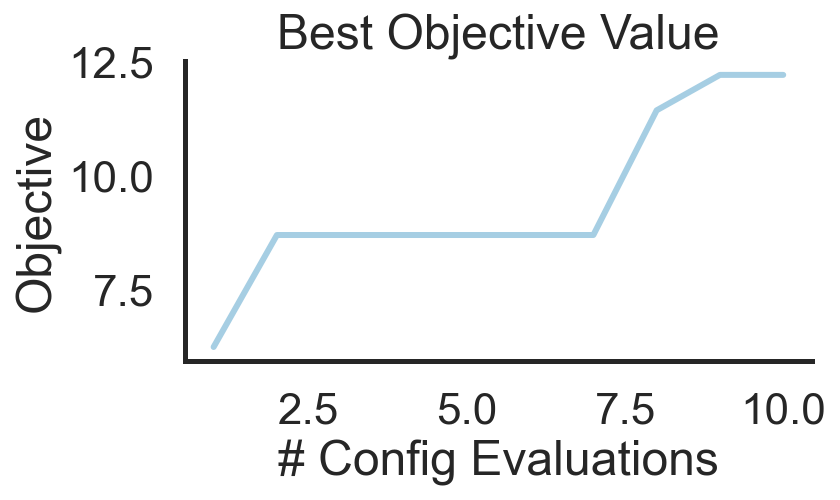

In [13]:
hyper_strategy.plot_best()

In [ ]:
from neuroevobench.blines import BayesOptJAX